# **Интерпретация моделей**

## **Важная информация**

**Для правильного воспроизведения результатов** решения задач:

* Рекомендуется придерживаться имеющего в заданиях кода в исходной последовательности. Для этого при решении задач **восстановите недостающие фрагменты кода, которые отмечены символом** `...` (Ellipsis).

* Если класс, функция или метод предусматривает параметр random_state, всегда указывайте **random_state=RANDOM_STATE**.

* Для всех параметров (кроме random_state) класса, функции или метода **используйте значения по умолчанию, если иное не указано в задании**.

**Если скорость обучения слишком низкая**, рекомендуется следующее:

* В модели или/и GridSearchCV поменяйте значение параметра n_jobs, который отвечает за параллелизм вычислений.

* Воспользуйтесь вычислительными ресурсами Google Colab или Kaggle.

***Использовать GPU не рекомендуется, поскольку результаты обучения некоторых моделей могут отличаться на CPU и GPU.***

После выполнения каждого задания **ответьте на вопросы в тесте.**

**ВНИМАНИЕ:** **После каждого нового запуска ноутбука** перед тем, как приступить к выполнению заданий, проверьте настройку виртуального окружения, выполнив код в ячейке ниже.

In [1]:
# Код для проверки настройки виртуального окружения

import sys
from importlib.metadata import version

required = {
    'python': '3.11.x',
    'numpy': '1.26.4',
    'pandas': '2.1.4',
    'scikit-learn': '1.7.0',
    'matplotlib': '3.8.0',
    'catboost': '1.2.8',
    'eli5': '0.16.0',
    'shap': '0.48.0'
}

print(f'{"Компонент":<15} | {"Требуется":<12} | {"Установлено":<12} | {"Соответствие"}')
print('-' * 62)

environment_ok = True
for lib, req_ver in required.items():
    try:
        if lib == 'python':
            inst_ver = sys.version.split()[0]
            status = '✓' if sys.version_info.major == 3 and sys.version_info.minor == 11 else f'x (требуется {req_ver})'
        else:
            inst_ver = version(lib)
            if inst_ver == req_ver:
                status = '✓'
            else:
                environment_ok = False
                status = f'x (требуется {req_ver})'
    except:
        environment_ok = False
        inst_ver = '-'
        status = 'x (не установлена)'
    print(f'{lib:<15} | {req_ver:<12} | {inst_ver:<12} | {status:<12}')

print('\nРезультат проверки: ', 
      '✓\nВсе версии соответствуют требованиям' 
      if environment_ok else 
      'x\nВНИМАНИЕ: Версии некоторых компонентов не соответствуют требованиям!\n'
      'Для решения проблемы обратитесь к инструкции по настройке виртуального окружения')

Компонент       | Требуется    | Установлено  | Соответствие
--------------------------------------------------------------
python          | 3.11.x       | 3.11.8       | ✓           
numpy           | 1.26.4       | 1.26.4       | ✓           
pandas          | 2.1.4        | 2.1.4        | ✓           
scikit-learn    | 1.7.0        | 1.7.0        | ✓           
matplotlib      | 3.8.0        | 3.8.0        | ✓           
catboost        | 1.2.8        | 1.2.8        | ✓           
eli5            | 0.16.0       | 0.16.0       | ✓           
shap            | 0.48.0       | 0.48.0       | ✓           

Результат проверки:  ✓
Все версии соответствуют требованиям


## **Импорт библиотек и вспомогательные функции**

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.compose import ColumnTransformer, make_column_selector

from catboost import CatBoostClassifier

import eli5
from eli5.sklearn import PermutationImportance

import shap
from shap import TreeExplainer

In [4]:
RANDOM_STATE = 42

## **Практическая часть**

### **Permutation Importance**

Permutation importance (вычисление важности с помощью перестановки) — это метод интерпретации моделей машинного обучения, используемый для количественной оценки вклада каждого признака в прогноз модели. Метод оценивает, насколько сильно ухудшается метрика качества модели после случайного перемешивания значений одного из признаков.

Если признак  действительно важен для модели, то его случайное перемешивание разрушает взаимосвязь между признаком и целевой переменной, что приводит к заметному снижению метрики (например, R² или MSE). Если признак неважен, то перемешивание не влияет или почти не влияет на качество модели.
                            
**Алгоритм вычисления:**

1. Модель $m$ обучается на обучающей выборке.

2. Вычисляется исходная метрика $s$ модели $m$ на валидационной выборке $D$.

3. Для каждого признака $j$:

    1. Для каждого повторения $k$ ($k=1,...,K$):

        1. Случайным образом перетасовывается столбец $j$ набора данных $D$ для создания нового набора данных $D_{k,j}$.

        2. Вычисляется метрика $s_{k,j}$ модели $m$ по данным $D_{k,j}$.

    2. Вычисляется важность $i_{j}$ для признака $j$ по формуле:
    
    $$i_{j}=s-\frac{1}{K}{\sum_{k=1}^{K}{s_{k,j}}}$$
    
    Чем больше $i_{j}$, тем сильнее вклад признака в качество модели.

**Применение:**

* Признаки с $i_{j}$, близкой к нулю, можно удалить без значимой потери качества модели.

* Значение $i_{j}$ позволяет ранжировать признаки по влиянию на модель.

Подробнее можно изучить по **ссылкам:**

* [Вычисление важности признаков с помощью перестановки | scikit-learn.ru](https://scikit-learn.ru/stable/modules/permutation_importance.html)

* [Permutation Feature Importance |christophm.github.io](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

### **Датасет *Red Wine Quality***

**Для решения задания 1 рассмотрим датасет [Red Wine Quality](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009).**

Датасет содержит информацию о физико-химических свойствах красных вин португальского сорта "Vinho Verde". Он включает в себя результаты лабораторных анализов и оценку качества экспертами.

Целевая переменная — признак quality (качество вина), представляющий собой оценку вина экспертами по шкале от 0 до 10.

Датасет содержит только числовые признаки:

* Кислотность: fixed acidity, volatile acidity, citric acid.

* Содержание сахара и хлоридов: residual sugar, chlorides.

* Уровень диоксида серы: free sulfur dioxide, total sulfur dioxide.

* Физические свойства: density, pH.

* Крепость: alcohol.

*Целевая переменная quality принимает целые значения от 0 до 10, в рамках решения задания предлагается использовать набор данных для решения задачи регрессии (предполагая непрерывность целевой переменной).*

### ***Задание 1***

Выполните предобработку датасета (см. код).

Обучите две модели:

* `sk_reg_wine` — линейная регрессия (sklearn LinearRegression).

* `rf_wine` — случайный лес (RandomForestRegressor) с n_estimators=100.

Оцените важность признаков с точки зрения:

* Абсолютных значений ('по модулю') коэффициентов регрессии `sk_reg_wine`.

* Оценок относительного вклада признаков случайного леса `rf_wine` ([RandomForestRegressor.feature_importances_](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-mean-decrease-in-impurity)).

* Значений permutation importance для `sk_reg_wine` **на валидационной выборке**.

* Значений permutation importance для `rf_wine` **на валидационной выборке**.

**ВНИМАНИЕ:** В рамках данного задания признаки масштабируются с помощью `wine_scaler` (StandardScaler). Для интерпретации коэффициентов линейной регрессии и важности признаков **осуществлять обратное преобразование не нужно**.

In [5]:
# Считайте набор данных

df_wine = pd.read_csv('wine.csv')
df_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [6]:
# Воспользуемся методом info для определения типов признаков

df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
# Воспользуемся методом nunique для определения числа уникальных значений в каждом из признаков

df_wine.nunique()

fixed acidity            96
volatile acidity        143
citric acid              80
residual sugar           91
chlorides               153
free sulfur dioxide      60
total sulfur dioxide    144
density                 436
pH                       89
sulphates                96
alcohol                  65
quality                   6
dtype: int64

In [8]:
# Выделите объясняемый фактор в отдельную переменную

X_wine, y_wine = df_wine.drop(columns=['quality']), df_wine['quality']

In [9]:
# Разделите датасет на обучающую (60%) и валидационную (40%) выборки
# Не забудьте зафиксировать RANDOM_STATE

X_wine_train, X_wine_val, y_wine_train, y_wine_val = train_test_split(
    X_wine, y_wine, test_size=0.4, random_state=RANDOM_STATE
)

In [10]:
# Масштабируйте все признаки
#   train -> fit_transform
#   test -> transform

wine_scaler = StandardScaler().set_output(transform='pandas')

X_wine_train = wine_scaler.fit_transform(X_wine_train)
X_wine_val = wine_scaler.transform(X_wine_val)

In [11]:
# Обучите sk_reg_wine (sklearn LinearRegression) на обучающей выборке

sk_reg_wine = LinearRegression()
sk_reg_wine.fit(X_wine_train, y_wine_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [12]:
# Оцените важность признаков sk_reg_wine с помощью permutation importance на валидационной выборке
# Не забудьте зафиксировать RANDOM_STATE

n_iter = 5

perm_sk_reg_wine = PermutationImportance(
    estimator=sk_reg_wine,
    n_iter=n_iter,
    random_state=RANDOM_STATE
)
perm_sk_reg_wine.fit(X_wine_val, y_wine_val)

eli5.show_weights(perm_sk_reg_wine, feature_names=X_wine_val.columns.tolist())

Weight,Feature
0.2204 ± 0.0600,alcohol
0.1713 ± 0.0519,volatile acidity
0.0847 ± 0.0073,sulphates
0.0261 ± 0.0138,total sulfur dioxide
0.0228 ± 0.0053,pH
0.0200 ± 0.0078,fixed acidity
0.0056 ± 0.0037,residual sugar
0.0045 ± 0.0019,free sulfur dioxide
0.0028 ± 0.0071,chlorides
-0.0036 ± 0.0078,density


In [13]:
# Обучите rf_wine (RandomForestRegressor) на обучающей выборке с n_estimators=100
# Не забудьте зафиксировать RANDOM_STATE

rf_wine = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
rf_wine.fit(X_wine_train, y_wine_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
# Оцените важность признаков rf_wine с помощью permutation importance на валидационной выборке
# Не забудьте зафиксировать RANDOM_STATE

n_iter = 5

perm_rf_wine = PermutationImportance(
    estimator=rf_wine,
    n_iter=n_iter,
    random_state=RANDOM_STATE
)
perm_rf_wine.fit(X_wine_val, y_wine_val)

eli5.show_weights(perm_rf_wine, feature_names=X_wine_val.columns.tolist())

Weight,Feature
0.3455 ± 0.0590,alcohol
0.2390 ± 0.0516,sulphates
0.1288 ± 0.0306,volatile acidity
0.0399 ± 0.0149,total sulfur dioxide
0.0239 ± 0.0056,pH
0.0212 ± 0.0056,fixed acidity
0.0183 ± 0.0054,residual sugar
0.0180 ± 0.0055,density
0.0149 ± 0.0130,free sulfur dioxide
0.0143 ± 0.0141,chlorides


In [15]:
# Создайте DataFrame с оценками важности признаков с точки зрения:
#   1. Абсолютных значений ('по модулю') коэффициентов регрессии sk_reg_wine
#   2. Оценок относительного вклада признаков случайного леса rf_wine (RandomForestRegressor.feature_importances_)
#   3. Значений permutation importance для sk_reg_wine на валидационной выборке
#   4. Значений permutation importance для rf_wine на валидационной выборке

wine_feat_importance = pd.DataFrame({
    'sk_reg_wine coef': np.abs(sk_reg_wine.coef_),
    'rf_wine importance': rf_wine.feature_importances_,
    'sk_reg_wine permutation importance': perm_sk_reg_wine.feature_importances_,
    'rf_wine permutation importance': perm_rf_wine.feature_importances_
},
index = list(X_wine_val.columns))
wine_feat_importance = wine_feat_importance.sort_values(by='sk_reg_wine coef')
wine_feat_importance

,sk_reg_wine coef,rf_wine importance,sk_reg_wine permutation importance,rf_wine permutation importance
free sulfur dioxide,0.029381,0.045689,0.004459,0.014883
residual sugar,0.034777,0.056958,0.005619,0.018325
fixed acidity,0.041333,0.049089,0.020046,0.021239
pH,0.048924,0.053494,0.022792,0.023949
density,0.051906,0.054371,-0.003613,0.017958
citric acid,0.066635,0.048651,-0.008619,-0.000753
chlorides,0.077785,0.057896,0.002810,0.014302
total sulfur dioxide,0.100136,0.067759,0.026085,0.039916
sulphates,0.124643,0.125629,0.084692,0.238968
volatile acidity,0.215310,0.124405,0.171332,0.128758


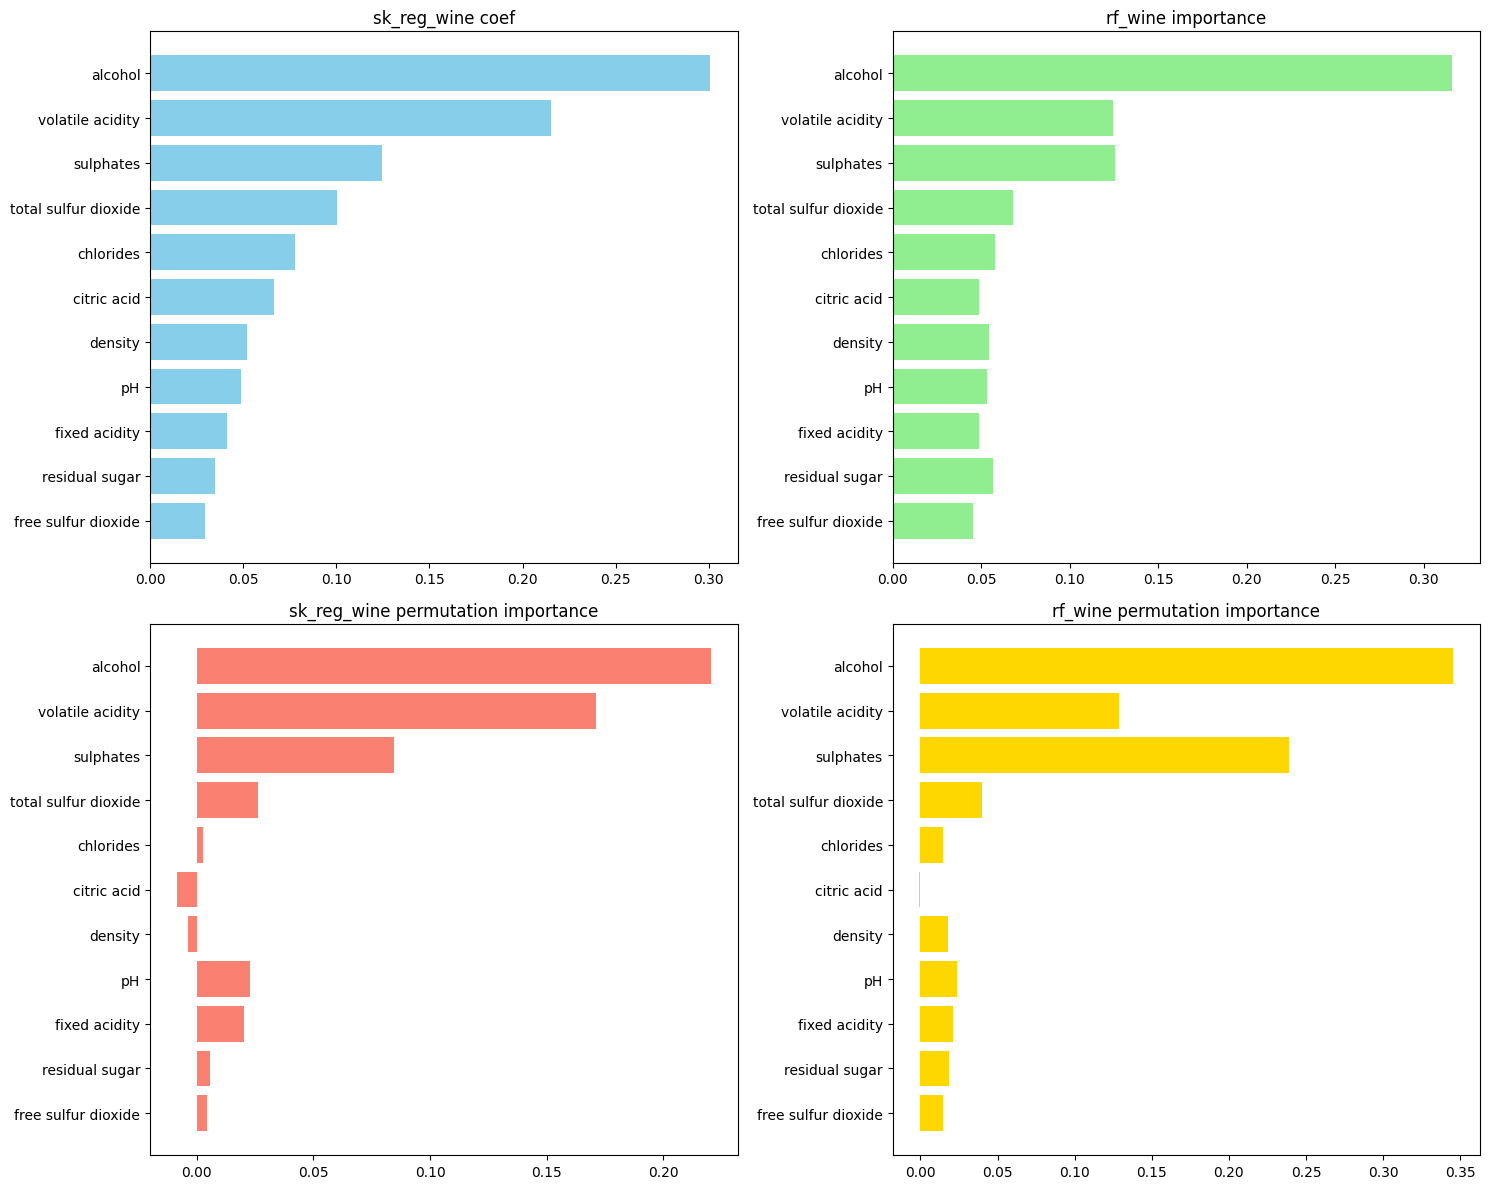

In [16]:
# Визуализируйте оценки важности признаков

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].barh(wine_feat_importance.index, wine_feat_importance['sk_reg_wine coef'], color='skyblue')
axes[0, 0].set_title('sk_reg_wine coef')

axes[0, 1].barh(wine_feat_importance.index, wine_feat_importance['rf_wine importance'], color='lightgreen')
axes[0, 1].set_title('rf_wine importance')

axes[1, 0].barh(wine_feat_importance.index, wine_feat_importance['sk_reg_wine permutation importance'], color='salmon')
axes[1, 0].set_title('sk_reg_wine permutation importance')

axes[1, 1].barh(wine_feat_importance.index, wine_feat_importance['rf_wine permutation importance'], color='gold')
axes[1, 1].set_title('rf_wine permutation importance')

plt.tight_layout()
plt.show()

# Resume 1

Описание задачи и методов
Исследование посвящено сравнительному анализу методов оценки важности признаков для предсказания качества вина по физико-химическим характеристикам. Набор данных содержит 1599 наблюдений и 11 числовых признаков, описывающих свойства вина. Целевая переменная - качество вина в диапазоне от 3 до 8 баллов.

Для анализа использовались четыре подхода: абсолютные значения коэффициентов линейной регрессии, встроенная важность признаков случайного леса, а также permutation importance для обеих моделей. Модели обучались на 60% данных с последующей валидацией на 40% выборке. Все признаки были стандартизированы с помощью StandardScaler.

Результаты оценки важности признаков
Анализ выявил четкую иерархию важности признаков. Алкоголь (alcohol) продемонстрировал наивысшую значимость во всех методах оценки: 0.300 по коэффициентам регрессии, 0.316 по важности случайного леса, 0.220 и 0.346 по permutation importance для линейной регрессии и случайного леса соответственно.

Летучая кислотность (volatile acidity) заняла второе место с показателями 0.215, 0.124, 0.171 и 0.129 по соответствующим метрикам. Сульфаты (sulphates) показали значения 0.125, 0.126, 0.085 и 0.239, демонстрируя особую важность для модели случайного леса.

Наименьшую предсказательную силу проявили свободный диоксид серы (free sulfur dioxide) с максимальным значением 0.045 и остаточный сахар (residual sugar) с максимальным значением 0.057. Эти признаки оказались малозначимыми across всех методов оценки.

Сравнительный анализ методов оценки
Методы продемонстрировали высокую согласованность в ранжировании признаков по важности. Коэффициенты линейной регрессии и permutation importance для обеих моделей выделили сходный набор наиболее значимых признаков. Различия наблюдались в абсолютных значениях оценок важности, что ожидаемо учитывая различную природу методов.

Permutation importance для случайного леса показала более выраженные различия между признаками по сравнению с другими методами. Значения permutation importance для линейной регрессии оказались консервативнее, с меньшим разбросом между наиболее и наименее важными признаками.

Выводы о применимости методов
Все рассмотренные методы оценки важности признаков дали согласованные результаты, что подтверждает надежность выявленной иерархии признаков. Комбинирование нескольких подходов позволяет получить более полное представление о значимости признаков и снизить риск переоценки или недооценки влияния отдельных переменных.

Для практического применения модели предсказания качества вина можно рекомендовать фокусироваться на признаках alcohol, volatile acidity и sulphates как наиболее информативных. Признаки free sulfur dioxide, residual sugar и fixed acidity могут быть исключены из модели без существенной потери точности для упрощения и ускорения прогнозирования.

Метод permutation importance показал себя как надежный инструмент для оценки важности признаков, особенно в сочетании с другими подходами. Его преимущество заключается в model-agnostic природе и интерпретируемости результатов.

### **Partial Dependence Plot**

Partial dependence plot (PDP, график частичной зависимости) — это метод интерпретации моделей машинного обучения, позволяющий визуализировать среднее влияние признаков на предсказания модели, усредняя влияние остальных признаков. PDP показывает, как в среднем изменяется прогноз модели при варьировании значений выбранного признака при неизменных значениях остальных признаков.

**Алгоритм вычисления:**

Пусть необходимо оценить PD для признака $S$.

1. Модель $m$ обучается на обучающей выборке.
    
2. Для каждого уникального значения $v$ (или для равномерно распределенной сетки) признака $S$:

    1. Все значения признака $S$ в валидационном датасете $D$ заменяются на $v$ для всех наблюдений (остальные признаки остаются неизменными) для создания нового набора данных $D_v$.

    2. Вычисляется : $\widehat{y}_i$.

    3. Вычисляется $PD(v)$:
    
    $$PD(v)=\frac{1}{N}\sum_{i=1}^{N}{\widehat{y}_i}$$
      
    где $\widehat{y}_i$ — прогноз модели $m$ на $D_v$ для наблюдения $i$.

    Полученное значение $PD(v)$ — partial dependence для значения $v$ признака $S$.

**Применение:**

* Визуализация характера влияния признака на прогноз модели:

    * Если кривая PDP почти горизонтальна, признак слабо влияет на предсказание.

    * Если PDP монотонно возрастает (или убывает), увеличение признака связано с ростом (или снижением) прогноза.
    
    * Если PDP нелинейный, то наблюдается сложная зависимость между признаком и целевой переменной.

* PDP используется для сравнения того, как разные модели интерпретируют влияние одного и того же признака.

Подробнее можно изучить по **ссылкам:**

* [Графики частичной зависимости (Partial dependence plots - PDP) | scikit-learn.ru](https://scikit-learn.ru/stable/modules/partial_dependence.html#partial-dependence-plots-pdp)

* [Partial Dependence Plot (PDP) | christophm.github.io](https://christophm.github.io/interpretable-ml-book/pdp.html)

### **Датасет *Hotel Reservations Dataset***

**Для решения заданий 2 — 4 рассмотрим датасет [Hotel Reservations Dataset](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset).**

**ВНИМАНИЕ:** При решении заданий **используйте файл hotels.csv** из приложения к ноутбуку, поскольку исходный датасет был изменен авторами курса.

Датасет содержит записи бронирования комнат в двух португальских отелях розничными и корпоративными клиентами, включая детали бронирования и статус бронирования.

Целевая переменная — booking_status (статус бронирования):

* Canceled — бронь была отменена клиентами до заселения.

* Not_Canceled — бронь не была отменена, клиенты заселились в отель.

Датасет содержит признаки:

* Количество гостей: no_of_adults, no_of_children.

* Время проживания: no_of_nights.

* Количество суток между бронированием и заселением: lead_time.

* Средняя стоимость аренды номера (евро): avg_price_per_room.

* Тип питания: type_of_meal_plan.

* Тип номера: room_type_reserved.

* Сегмент рынка: market_segment_type.

* Требуется ли парковка: required_car_parking_space.

* Количество специальных услуг: no_of_special_requests.

* Дата заселения: arrival_year, arrival_month, arrival_date.

* История клиента: repeated_guest, no_of_previous_cancellations, no_of_previous_bookings_not_canceled.

### ***Задание 2***

Выполните предобработку датасета (см. код).

Обучите две модели, предварительно подобрав оптимальные гиперпараметры обучения для каждой их них с помощью GridSearchCV:

* `lr_hotels` — логистическая регрессия (LogisticRegression). Для обучения и валидации используйте `X_hotels_train_scaled` и `X_hotels_val_scaled`.

* `rf_hotels` —  случайный лес (RandomForestClassifier) с n_estimators=100. Для обучения и валидации используйте `X_hotels_train_scaled` и `X_hotels_val_scaled`.

Для моделей `lr_hotels` и `rf_hotels` постройте отчёты по метрикам классификации и рассчитайте AUC **на валидационной выборке**.

Оцените важность признаков для моделей `lr_hotels` и `rf_hotels` с точки зрения permutation importance **на валидационной выборке (метрика — 'roc_auc')** и выделите **два наиболее важных признака** для `rf_hotels` — `hotels_important_features`.

Постройте partial dependence plot (PDP) признаков `hotels_important_features` для моделей `lr_hotels` и `rf_hotels` **на валидационной выборке**.

In [17]:
# Считайте набор данных

df_hotels = pd.read_csv('hotels.csv')
df_hotels

,no_of_nights,no_of_adults,no_of_children,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,3,2,0,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,5,2,0,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,3,1,0,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,2,2,0,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,2,2,0,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35725,8,3,0,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
35726,4,2,0,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
35727,8,2,0,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
35728,3,2,0,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


In [18]:
# Воспользуемся методом info для определения типов признаков

df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35730 entries, 0 to 35729
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_nights                          35730 non-null  int64  
 1   no_of_adults                          35730 non-null  int64  
 2   no_of_children                        35730 non-null  int64  
 3   type_of_meal_plan                     35730 non-null  object 
 4   required_car_parking_space            35730 non-null  int64  
 5   room_type_reserved                    35730 non-null  object 
 6   lead_time                             35730 non-null  int64  
 7   arrival_year                          35730 non-null  int64  
 8   arrival_month                         35730 non-null  int64  
 9   arrival_date                          35730 non-null  int64  
 10  market_segment_type                   35730 non-null  object 
 11  repeated_guest 

In [19]:
# Воспользуемся методом nunique для подсчета количества уникальных значений переменных в датасете

df_hotels.nunique()

no_of_nights                              24
no_of_adults                               5
no_of_children                             6
type_of_meal_plan                          4
required_car_parking_space                 2
room_type_reserved                         7
lead_time                                352
arrival_year                               2
arrival_month                             12
arrival_date                              31
market_segment_type                        5
repeated_guest                             2
no_of_previous_cancellations               9
no_of_previous_bookings_not_canceled      59
avg_price_per_room                      3929
no_of_special_requests                     6
booking_status                             2
dtype: int64

In [20]:
# Рассмотрим соотношение долей классов в датасете

df_hotels['booking_status'].value_counts(normalize=True)

booking_status
Not_Canceled    0.667534
Canceled        0.332466
Name: proportion, dtype: float64

In [21]:
# Выделите объясняемый фактор в отдельную переменную

X_hotels, y_hotels = df_hotels.drop(columns=['booking_status']), df_hotels['booking_status']

In [22]:
# Закодируйте объясняемый фактор как бинарную переменную:
#   Not_Canceled — 0
#   Canceled — 1

y_hotels = y_hotels.map({'Not_Canceled': 0, 'Canceled': 1})

In [23]:
# Создайте списки количественных и категориальных переменных (не включая целевую переменную)

hotels_num_feat = ['no_of_nights', 'no_of_adults', 'no_of_children', 'lead_time', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
hotels_cat_feat = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'market_segment_type', 'repeated_guest', 'arrival_year', 'arrival_month', 'arrival_date']

In [24]:
# Разделите датасет на обучающую (60%) и валидационную (40%) выборки со стратификацией по целевой переменной
# Выполните сброс индексов в полученных датасетах
# Не забудьте зафиксировать RANDOM_STATE

X_hotels_train, X_hotels_val, y_hotels_train, y_hotels_val = train_test_split(
    X_hotels, y_hotels, test_size=0.4, stratify=y_hotels, random_state=RANDOM_STATE
)

X_hotels_train = X_hotels_train.reset_index(drop=True)
y_hotels_train.index = X_hotels_train.index
X_hotels_val = X_hotels_val.reset_index(drop=True)
y_hotels_val.index = X_hotels_val.index

In [25]:
# Закодируйте категориальные признаки числами 0 и 1 с помощью OneHotEncoder
# Выделите отдельные датасеты с закодированными признаками
#   train -> fit_transform
#   val -> transform

hotels_encoder = OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas')

X_hotels_train_onehot = hotels_encoder.fit_transform(X_hotels_train[hotels_cat_feat])
X_hotels_val_onehot = hotels_encoder.transform(X_hotels_val[hotels_cat_feat])

In [26]:
# Масштабируйте количественные признаки
#   train -> fit_transform
#   val -> transform

hotels_scaler = StandardScaler().set_output(transform='pandas')

X_hotels_train_onehot_scaled = hotels_scaler.fit_transform(X_hotels_train[hotels_num_feat])
X_hotels_val_onehot_scaled = hotels_scaler.transform(X_hotels_val[hotels_num_feat])

hotels_onehot_scaled_cols = list(X_hotels_train_onehot_scaled.columns)

In [27]:
# Подберите оптимальные гиперпараметры обучения lr_hotels с помощью GridSearchCV
# Обучите lr_hotels с оптимальными параметрами
# Не забудьте зафиксировать RANDOM_STATE

params = {
    'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
}
scoring = 'roc_auc'
cv = 5

cv_lr_hotels = GridSearchCV(
    estimator=LogisticRegression(random_state=RANDOM_STATE),
    param_grid=params,
    scoring=scoring,
    cv=cv
).fit(X_hotels_train_onehot_scaled, y_hotels_train)

lr_hotels = cv_lr_hotels.best_estimator_

In [28]:
# Постройте отчёт по метрикам классификации для lr_hotels на валидационной выборке

print(classification_report(y_hotels_val, lr_hotels.predict(X_hotels_val_onehot_scaled), digits=4))

              precision    recall  f1-score   support

           0     0.7914    0.8957    0.8403      9540
           1     0.7153    0.5261    0.6063      4752

    accuracy                         0.7728     14292
   macro avg     0.7534    0.7109    0.7233     14292
weighted avg     0.7661    0.7728    0.7625     14292



In [29]:
# Рассчитайте AUC для lr_hotels на валидационной выборке

roc_auc_score(y_hotels_val, lr_hotels.predict_proba(X_hotels_val_onehot_scaled)[:, 1])

0.8222250898220499

In [30]:
# Оцените важность признаков для lr_hotels с точки зрения permutation importance на валидационной выборке (метрика — 'roc_auc')

n_iter = 5
scoring = 'roc_auc'

perm_lr_hotels = PermutationImportance(
    estimator=lr_hotels,
    n_iter=n_iter,
    random_state=RANDOM_STATE,
    scoring=scoring
)
perm_lr_hotels.fit(X_hotels_val_onehot_scaled, y_hotels_val)

eli5.show_weights(perm_lr_hotels, top=len(hotels_onehot_scaled_cols), feature_names=hotels_onehot_scaled_cols)

Weight,Feature
0.1751 ± 0.0043,lead_time
0.0958 ± 0.0039,no_of_special_requests
0.0456 ± 0.0027,avg_price_per_room
0.0093 ± 0.0025,no_of_previous_bookings_not_canceled
0.0048 ± 0.0012,no_of_nights
0.0005 ± 0.0005,no_of_adults
0.0000 ± 0.0002,no_of_children
-0.0001 ± 0.0002,no_of_previous_cancellations


In [31]:
# Подберите оптимальные гиперпараметры обучения rf_hotels (RandomForestClassifier) с помощью GridSearchCV
# Обучите rf_hotels с оптимальными параметрами
# Не забудьте зафиксировать RANDOM_STATE

params = {
    'max_depth': [None, 6, 7, 8, 9],
    'n_estimators': [50, 100, 150]
}
scoring = 'roc_auc'
cv = 5

cv_rf_hotels = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid=params,
    scoring=scoring,
    cv=cv
).fit(X_hotels_train_onehot_scaled, y_hotels_train)

rf_hotels = cv_rf_hotels.best_estimator_

In [32]:
# Постройте отчёт по метрикам классификации для rf_hotels на валидационной выборке

print(classification_report(y_hotels_val, rf_hotels.predict(X_hotels_val_onehot_scaled), digits=4))

              precision    recall  f1-score   support

           0     0.8783    0.9209    0.8991      9540
           1     0.8240    0.7439    0.7819      4752

    accuracy                         0.8620     14292
   macro avg     0.8512    0.8324    0.8405     14292
weighted avg     0.8603    0.8620    0.8601     14292



In [33]:
# Рассчитайте AUC для rf_hotels на валидационной выборке

roc_auc_score(y_hotels_val, rf_hotels.predict_proba(X_hotels_val_onehot_scaled)[:, 1])

0.9200665812563087

In [34]:
# Оцените важность признаков для rf_hotels с точки зрения permutation importance на валидационной выборке (метрика — 'roc_auc')

n_iter = 5
scoring = 'roc_auc'

perm_rf_hotels = PermutationImportance(
    estimator=rf_hotels,
    n_iter=n_iter,
    random_state=RANDOM_STATE,
    scoring=scoring
)
perm_rf_hotels.fit(X_hotels_val_onehot_scaled, y_hotels_val)

eli5.show_weights(perm_rf_hotels, feature_names=hotels_onehot_scaled_cols)

Weight,Feature
0.2662 ± 0.0036,lead_time
0.1567 ± 0.0031,avg_price_per_room
0.1215 ± 0.0040,no_of_special_requests
0.0534 ± 0.0033,no_of_nights
0.0353 ± 0.0023,no_of_adults
0.0052 ± 0.0006,no_of_children
0.0027 ± 0.0009,no_of_previous_bookings_not_canceled
0.0009 ± 0.0003,no_of_previous_cancellations


In [35]:
# Выделите 2 наиболее важных признака для rf_hotels с точки зрения permutation importance в список

hotels_important_features = ['lead_time', 'avg_price_per_room']

In [36]:
hotels_important_features

['lead_time', 'avg_price_per_room']

[]

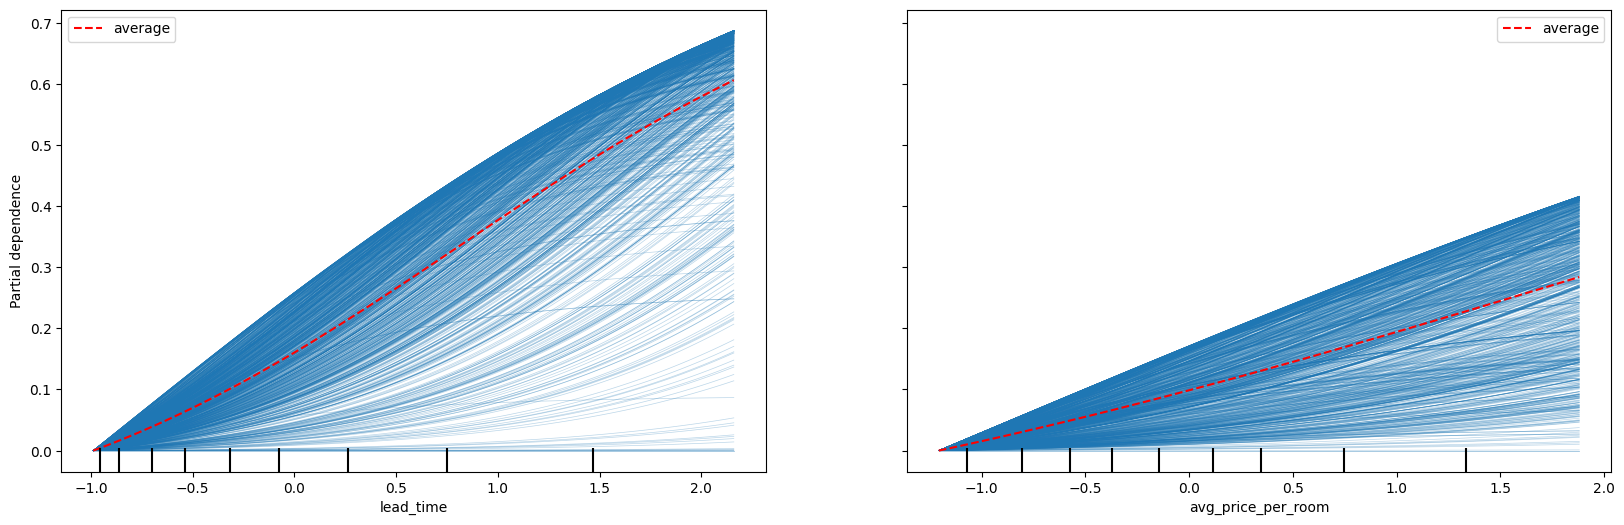

In [37]:
# Постройте PDP признаков hotels_important_features для lr_hotels на валидационной выборке

fig, ax = plt.subplots(figsize=(20, 6))
PartialDependenceDisplay.from_estimator(
    estimator=lr_hotels, 
    X=X_hotels_val_onehot_scaled, 
    features=hotels_important_features,
    centered=True,
    ax=ax,
    kind='both',
    pd_line_kw={'color': 'red'}
)
ax.plot()

[]

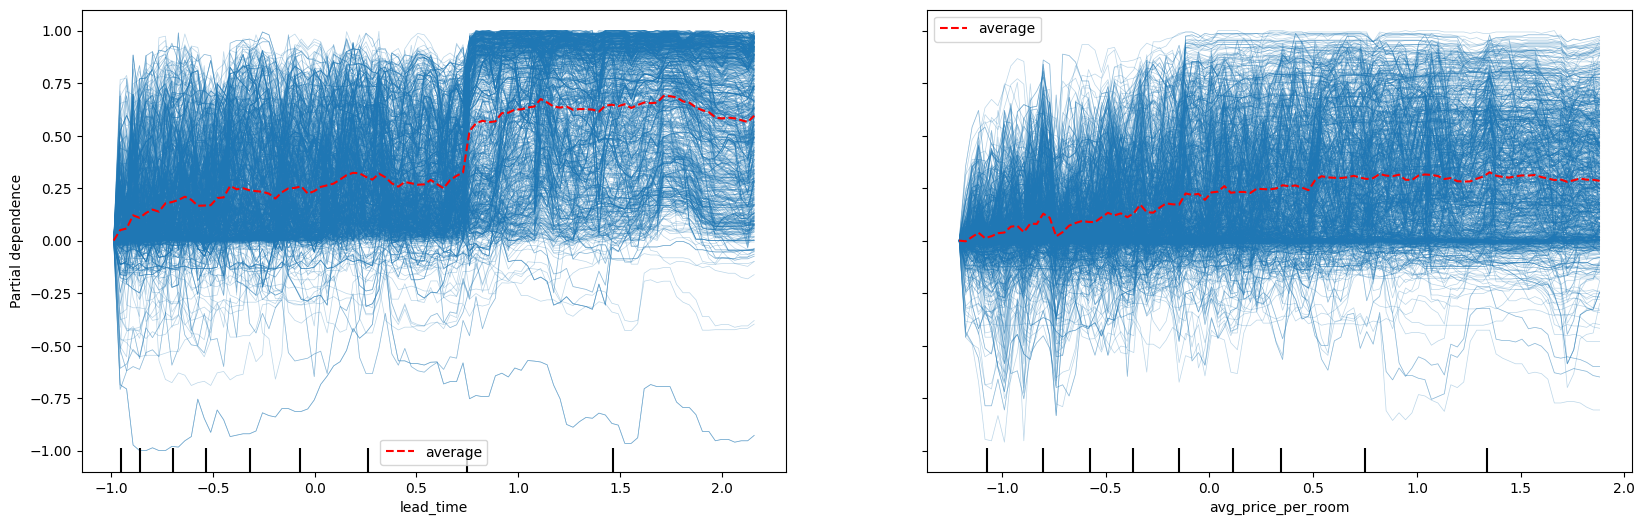

In [38]:
# Постройте PDP признаков hotels_important_features для rf_hotels на валидационной выборке

fig, ax = plt.subplots(figsize=(20, 6))
PartialDependenceDisplay.from_estimator(
    estimator=rf_hotels, 
    X=X_hotels_val_onehot_scaled, 
    features=hotels_important_features,
    centered=True,
    ax=ax,
    kind='both',
    pd_line_kw={'color': 'red'}
)
ax.plot()

### **SHAP**

SHAP (SHapley Additive exPlanations) — это метод интерпретации моделей машинного обучения, объясняющий предсказание для каждого отдельного объекта как сумму аддитивных вкладов его признаков. 

Метод основан на значениях Шепли — концепции из кооперативной теории игр, которая позволяет справедливо распределить "выигрыш" (в данном случае, значение прогноза модели) между "игроками" (признаками). 

Идея метода состоит в оценке вклада каждого признака в отклонение конкретного предсказания от среднего предсказания модели по всей выборке. 

SHAP позволяет понять вклад каждого признака в конкретный прогноз.  Усреднение SHAP-вкладов по всем объектам даёт глобальную характеристику важности признаков.

**Применение:**

* Force Plot — визуализация важности признаков для отдельного предсказания, визуально показывающее вклад каждого признака в итоговое значение.

* Summary Plot — сводная визуализация вклада признаков по всему датасету, показывающая распределение и важность признаков.

* Dependence Plot — график зависимости вклада признака от его значения, позволяющий выявить нелинейные эффекты и взаимодействия.

Подробнее можно изучить по **ссылкам:**

* [An introduction to explainable AI with Shapley values | shap.readthedocs.io](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)

* [SHAP | christophm.github.io](https://christophm.github.io/interpretable-ml-book/shap.html)

### ***Задание 3***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую и валидационную выборки из задания 2 **до One-Hot кодирования и масштабирования**: `X_hotels_train`, `y_hotels_train`, `X_hotels_val`, `y_hotels_val`.

Обучите модель `catb_hotels` (CatBoostClassifier) c параметрами по умолчанию.

Постройте отчёт по метрикам классификации для модели и рассчитайте AUC **на валидационной выборке** для модели `catb_hotels`.

**Используя валидационную выборку**, вычислите SHAP-значения с помощью [TreeExplainer](https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html): `hotels_shap_values`.

Визуализуйте и интерпретируйте глобальную важность признаков, построив для `hotels_shap_values` графики [barplot](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html#Global-bar-plot) и [beeswarm](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html#beeswarm-plot).

In [39]:
# Обучите модель catb_hotels (CatBoostClassifier) c параметрами по умолчанию (и params)
# Для обучения и валидации используйте X_hotels_train и X_hotels_val

params = {
    'cat_features': hotels_cat_feat,
    'random_state': RANDOM_STATE,
    'verbose': False
}

catb_hotels = CatBoostClassifier(**params).fit(X_hotels_train, y_hotels_train)

In [40]:
# Общее количество признаков (для визуализации shap)

hotels_feat_count = len(X_hotels_train.columns)

In [41]:
# Постройте отчёт по метрикам классификации для catb_hotels на валидационной выборке

print(classification_report(y_hotels_val, catb_hotels.predict(X_hotels_val), digits=4))

              precision    recall  f1-score   support

           0     0.8933    0.9332    0.9128      9540
           1     0.8528    0.7763    0.8127      4752

    accuracy                         0.8811     14292
   macro avg     0.8730    0.8548    0.8628     14292
weighted avg     0.8798    0.8811    0.8796     14292



In [42]:
# Рассчитайте AUC для catb_hotels на валидационной выборке

roc_auc_score(y_hotels_val, catb_hotels.predict_proba(X_hotels_val)[:, 1])

0.9441619748321792

In [43]:
# Вычислите SHAP-значения для валидационной выборки, используя TreeExplainer

hotels_shap_explainer = shap.TreeExplainer(catb_hotels)
hotels_shap_values = hotels_shap_explainer.shap_values(X_hotels_val)

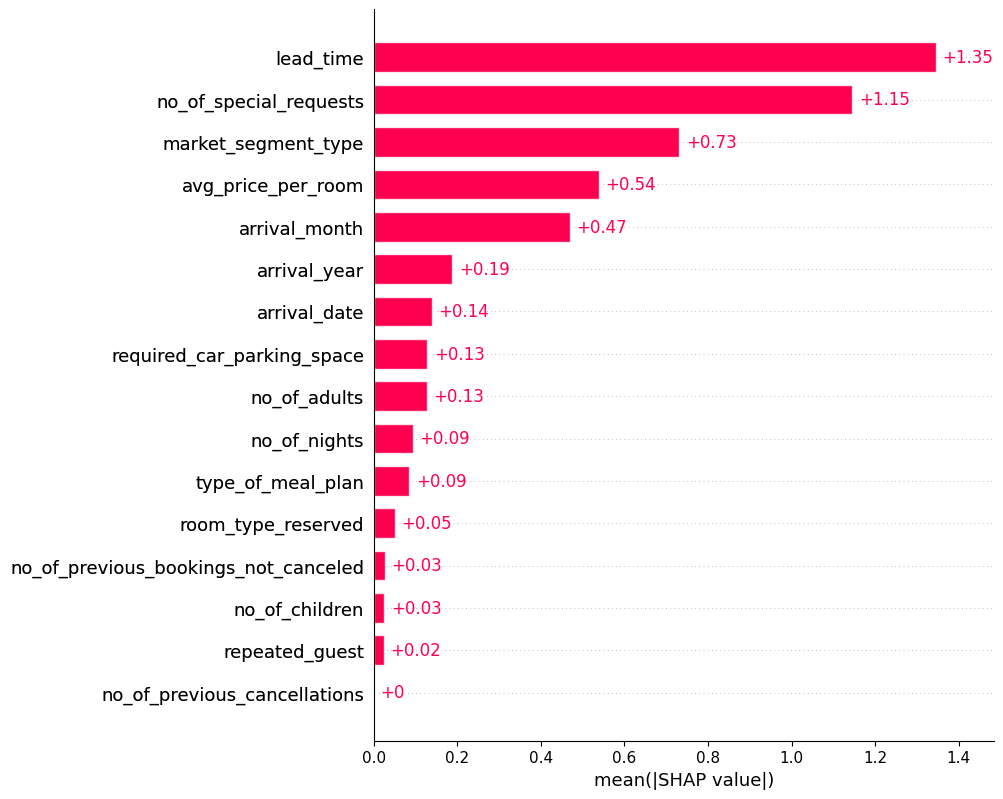

In [44]:
# Постройте barplot SHAP-значений

hotels_shap_explanation = shap.Explanation(
    values=hotels_shap_values,
    base_values=hotels_shap_explainer.expected_value,
    data=X_hotels_val.values,
    feature_names=X_hotels_val.columns.tolist()
)

# Bar plot
shap.plots.bar(hotels_shap_explanation, max_display=hotels_feat_count)

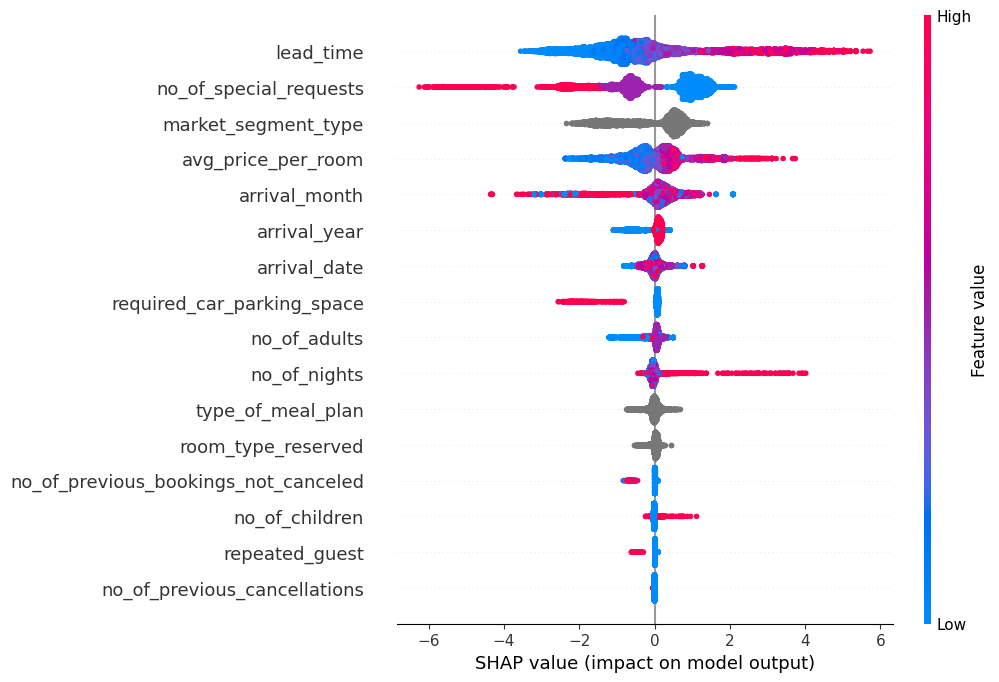

In [45]:
# Постройте beeswarm SHAP-значений

shap.plots.beeswarm(hotels_shap_explanation, max_display=hotels_feat_count)

### ***Задание 4***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Валидационную выборка из задания 2 **до One-Hot кодирования и масштабирования**: `X_hotels_val`, `y_hotels_val`.

* SHAP-значения из задания 3: `hotels_shap_values`.

В рамках валидационной выборки `X_hotels_val` выделите три группы клиентов отелей по признакам (используйте метод [query](https://pandas.pydata.org/docs/user_guide/indexing.html#the-query-method)):

* **Группа 1.** Брони семей с детьми (количество взрослых — больше одного, количество детей — как минимум один) в недорогих номерах (средняя стоимость аренды номера строго меньше 90 евро).

* **Группа 2.** Брони новых (repeated_guest — 0) корпоративных клиентов (сегмент рынка — "Corporate") на одну ночь (время пребывания — одна ночь).

* **Группа 3.** Брони клиентов, которые забронировали номер через оффлайн-канал (сегмент рынка — "Offline") на срок более пяти ночей (время пребывания — строго больше 5 ночей).

Визуализуйте и интерпретируйте важность признаков для каждой из выделенных групп, построив для SHAP-значений [beeswarm](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html#beeswarm-plot) график.

Используя метод [sample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html), для каждой из выделенных групп выберите по одной случайной записи (**не забудьте зафиксировать RANDOM_STATE**):

* Случайная бронь из группы 1. 

* Случайная бронь из группы 2. 

* Случайная бронь из группы 3. 

Визуализуйте и интерпретируйте важность признаков для каждой из трех случайных записей, построив для SHAP-значений графики: [waterfall](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html#waterfall-plot) и [force plot](https://shap.readthedocs.io/en/latest/generated/shap.plots.force.html).

##### Группа 1

In [46]:
# Из валидационной выборки выделите группу 1
# Подсказка: используйте метод query

X_hotels_group_1 = X_hotels_val.query('no_of_adults > 1 and no_of_children >= 1 and avg_price_per_room < 90')

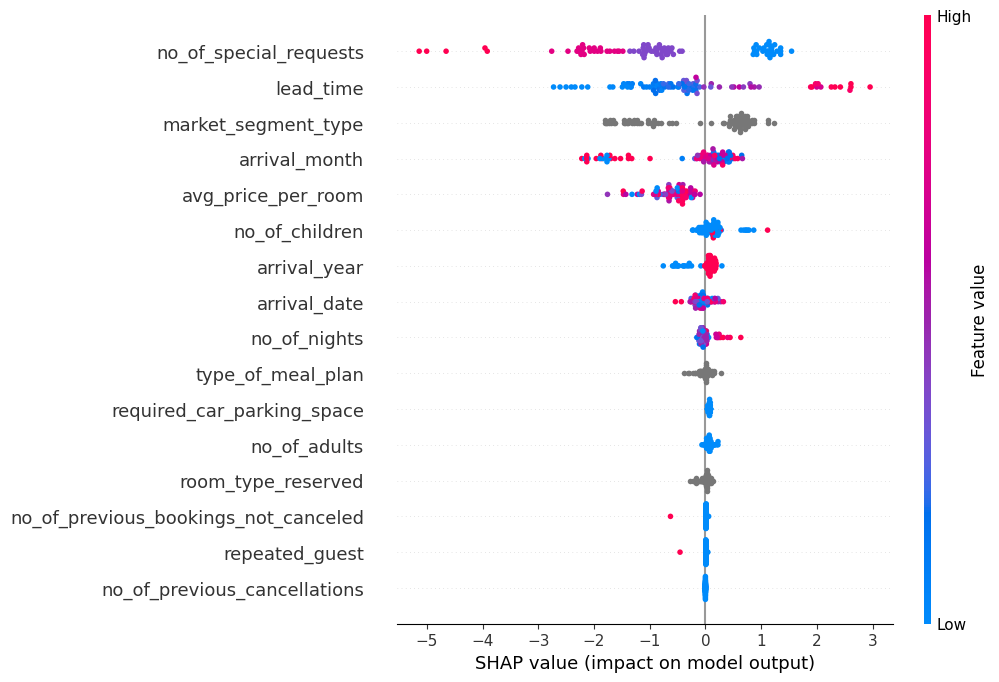

In [ ]:
# Получаем индексы группы 1
group_1_indices = X_hotels_val.query('no_of_adults > 1 and no_of_children >= 1 and avg_price_per_room < 90').index

# Создаем Explanation object для группы 1
hotels_shap_explanation_group_1 = shap.Explanation(
    values=hotels_shap_values[group_1_indices],
    base_values=hotels_shap_explainer.expected_value,
    data=X_hotels_val.iloc[group_1_indices].values,
    feature_names=X_hotels_val.columns.tolist()
)

shap.plots.beeswarm(hotels_shap_explanation_group_1, max_display=hotels_feat_count)

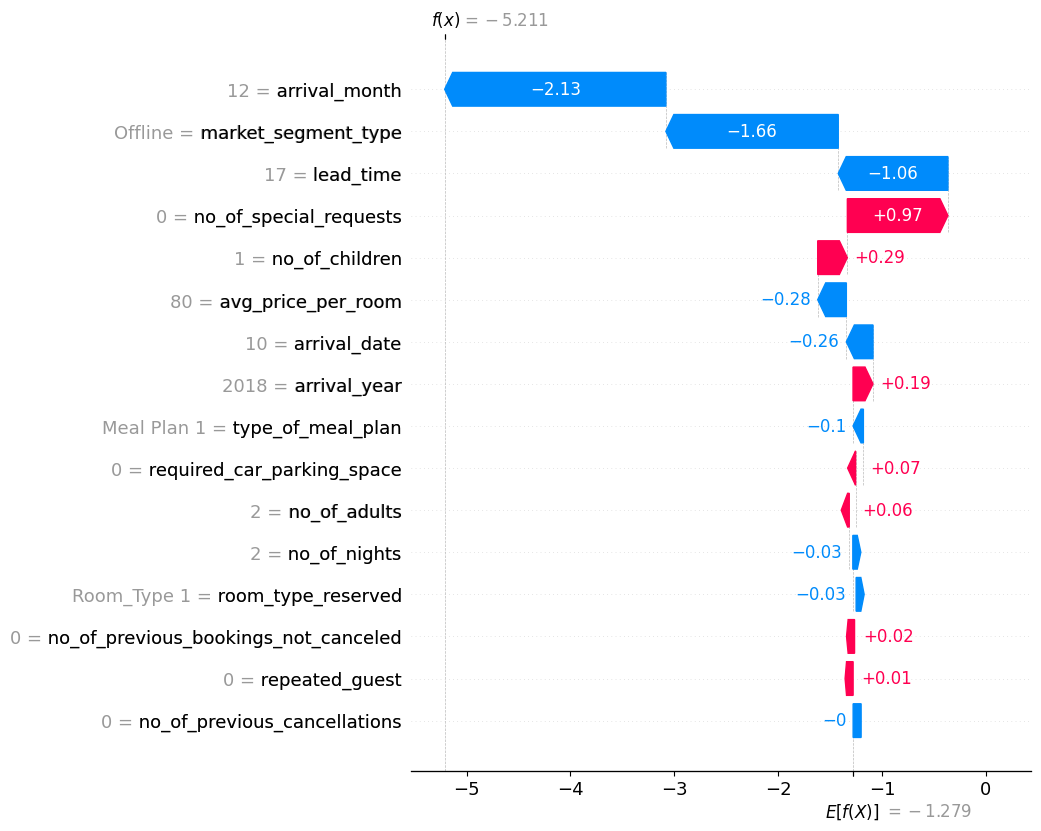

In [ ]:
# Выберите случайную запись из группы 1 
# Не забудьте зафиксировать RANDOM_STATE

# Постройте waterfall SHAP-значений для записи из группы 1

group_1_first_index = group_1_indices[0]

shap.plots.waterfall(hotels_shap_explanation[group_1_first_index], max_display=hotels_feat_count)

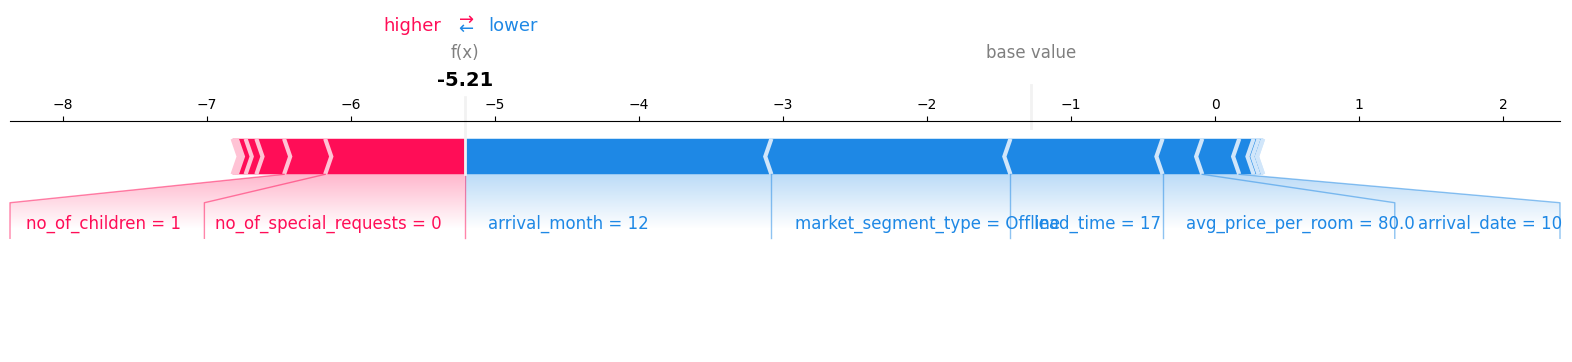

In [ ]:
# Постройте force plot SHAP-значений для записи из группы 1

shap.plots.force(hotels_shap_explanation[group_1_first_index], matplotlib=True)

##### Группа 2

In [ ]:
# Из валидационной выборки выделите группу 2
# Подсказка: используйте метод query

X_hotels_group_2 = X_hotels_val.query('repeated_guest == 0 and market_segment_type == "Corporate" and no_of_nights == 1')

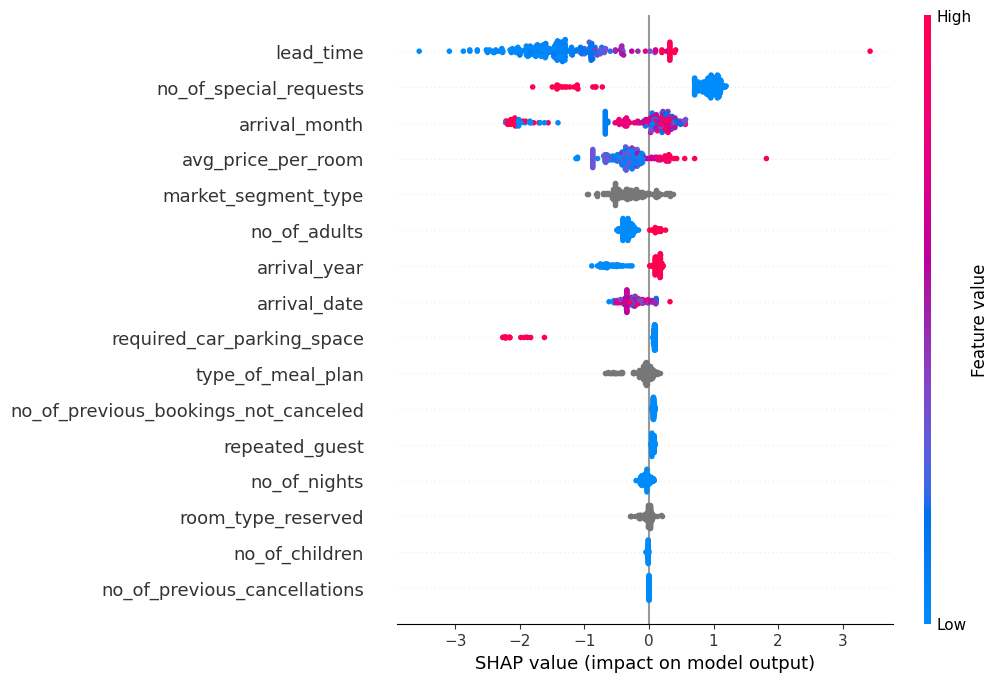

In [ ]:
# Постройте beeswarm SHAP-значений для группы 2

# Получаем индексы группы 2
group_2_indices = X_hotels_val.query('repeated_guest == 0 and market_segment_type == "Corporate" and no_of_nights == 1').index

# Создаем Explanation object для группы 2
hotels_shap_explanation_group_2 = shap.Explanation(
    values=hotels_shap_values[group_2_indices],
    base_values=hotels_shap_explainer.expected_value,
    data=X_hotels_val.iloc[group_2_indices].values,
    feature_names=X_hotels_val.columns.tolist()
)

shap.plots.beeswarm(hotels_shap_explanation_group_2, max_display=hotels_feat_count)

In [ ]:
# Выберите случайную запись из группы 2
# Не забудьте зафиксировать RANDOM_STATE

rng = np.random.RandomState(RANDOM_STATE)
X_hotels_group_2_sample = X_hotels_group_2.sample(n=1, random_state=RANDOM_STATE)

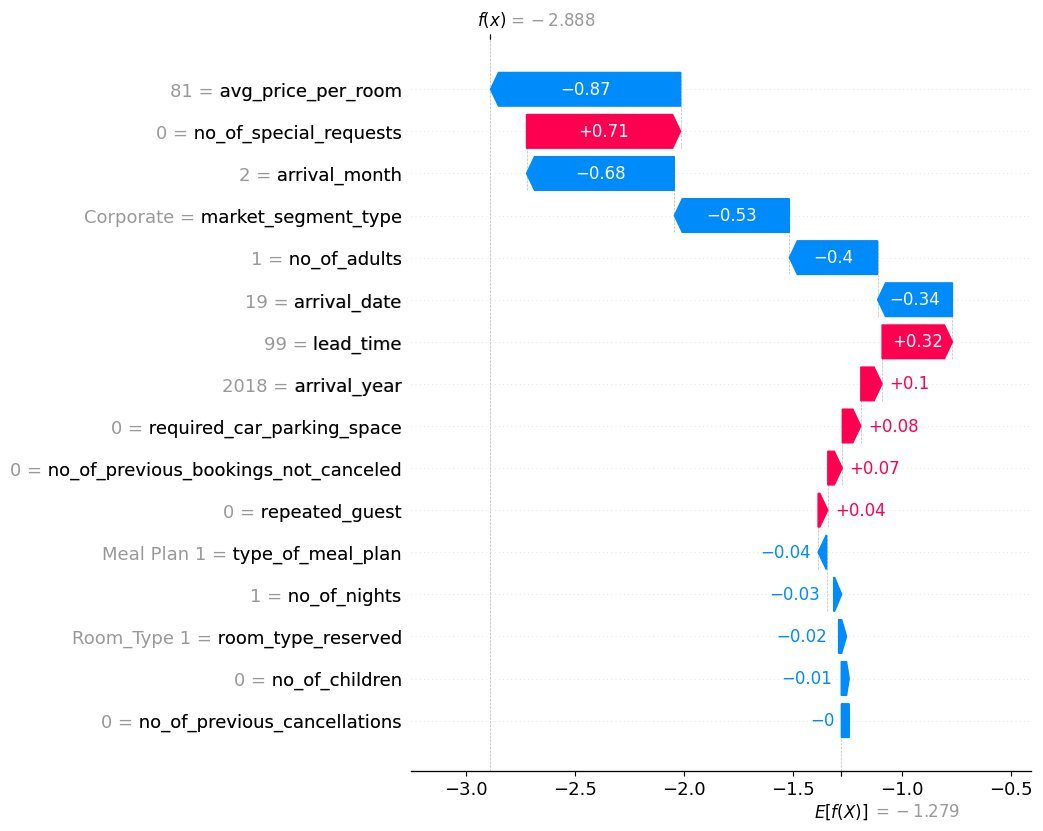

In [ ]:
# Постройте waterfall SHAP-значений для записи из группы 2

group_2_sample_index = X_hotels_group_2_sample.index[0]

shap.plots.waterfall(hotels_shap_explanation[group_2_sample_index], max_display=hotels_feat_count)

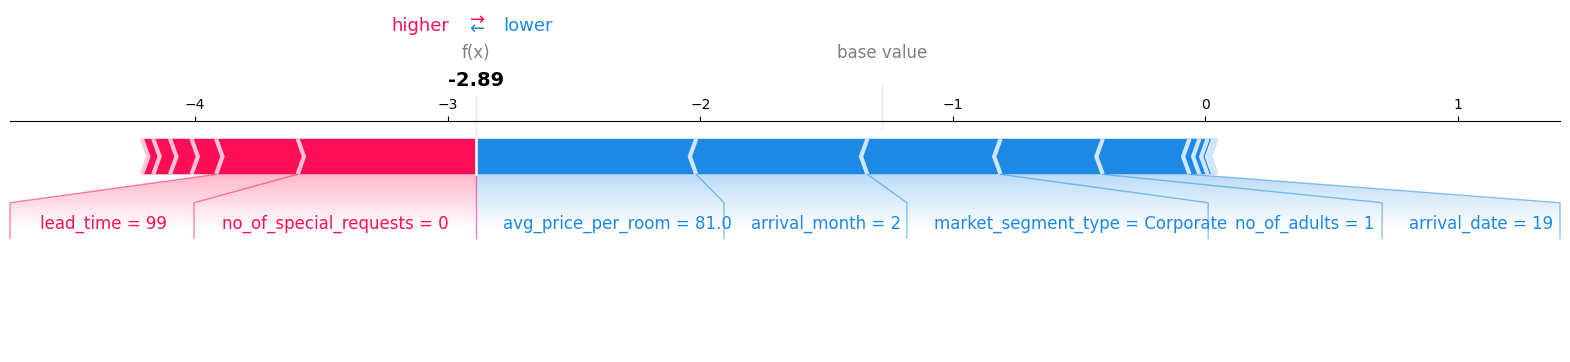

In [ ]:
# Постройте force plot SHAP-значений для записи из группы 2

shap.plots.force(hotels_shap_explanation[group_2_sample_index], matplotlib=True)

##### Группа 3

In [ ]:
# Из валидационной выборки выделите группу 3
# Подсказка: используйте метод query

X_hotels_group_3 = X_hotels_val.query('market_segment_type == "Offline" and no_of_nights > 5')

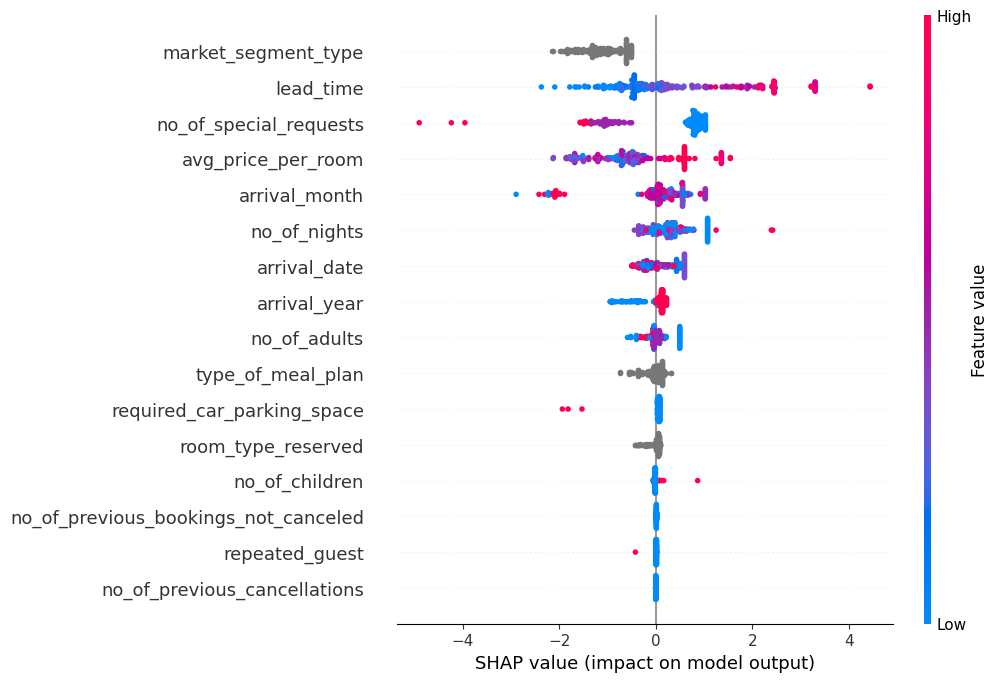

In [ ]:
# Постройте beeswarm SHAP-значений для группы 3

# Получаем индексы группы 3
group_3_indices = X_hotels_val.query('market_segment_type == "Offline" and no_of_nights > 5').index

# Создаем Explanation object для группы 3
hotels_shap_explanation_group_3 = shap.Explanation(
    values=hotels_shap_values[group_3_indices],
    base_values=hotels_shap_explainer.expected_value,
    data=X_hotels_val.iloc[group_3_indices].values,
    feature_names=X_hotels_val.columns.tolist()
)

shap.plots.beeswarm(hotels_shap_explanation_group_3, max_display=hotels_feat_count)

In [ ]:
# Выберите случайную запись из группы 3
# Не забудьте зафиксировать RANDOM_STATE

X_hotels_group_3_sample = X_hotels_group_3.sample(n=1, random_state=RANDOM_STATE)

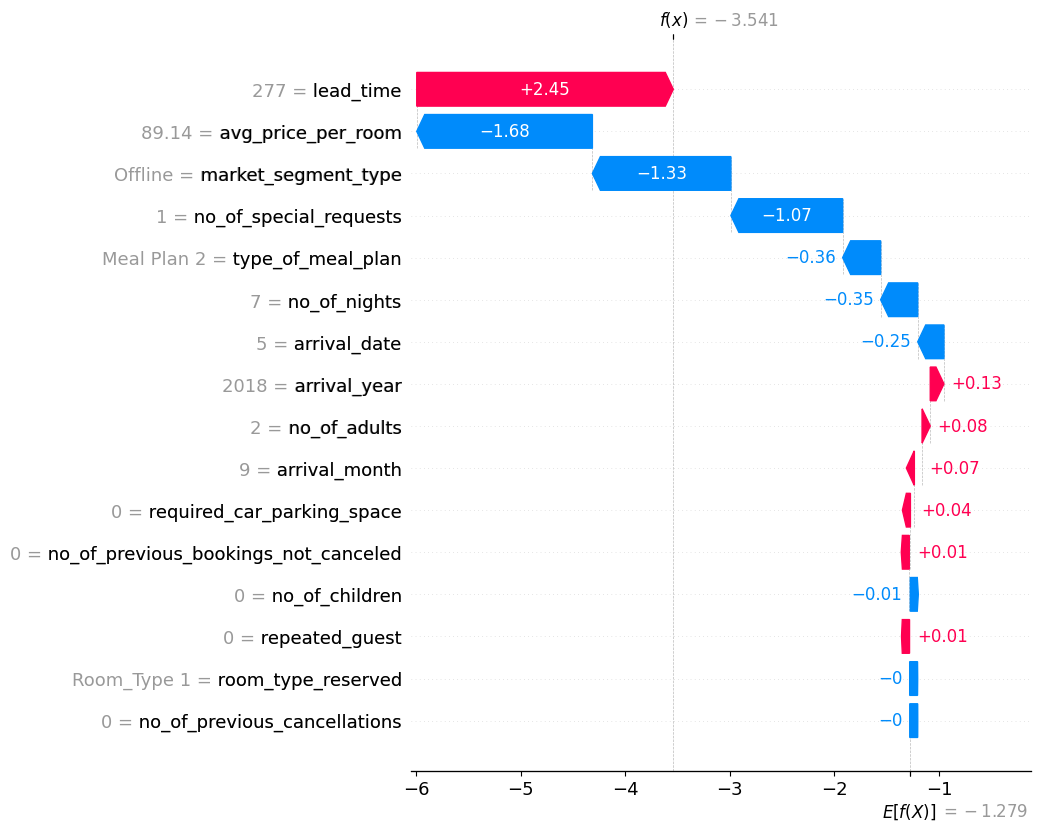

In [ ]:
# Постройте waterfall SHAP-значений для записи из группы 3

# Получаем индекс выбранной записи
group_3_sample_index = X_hotels_group_3_sample.index[0]

shap.plots.waterfall(hotels_shap_explanation[group_3_sample_index], max_display=hotels_feat_count)

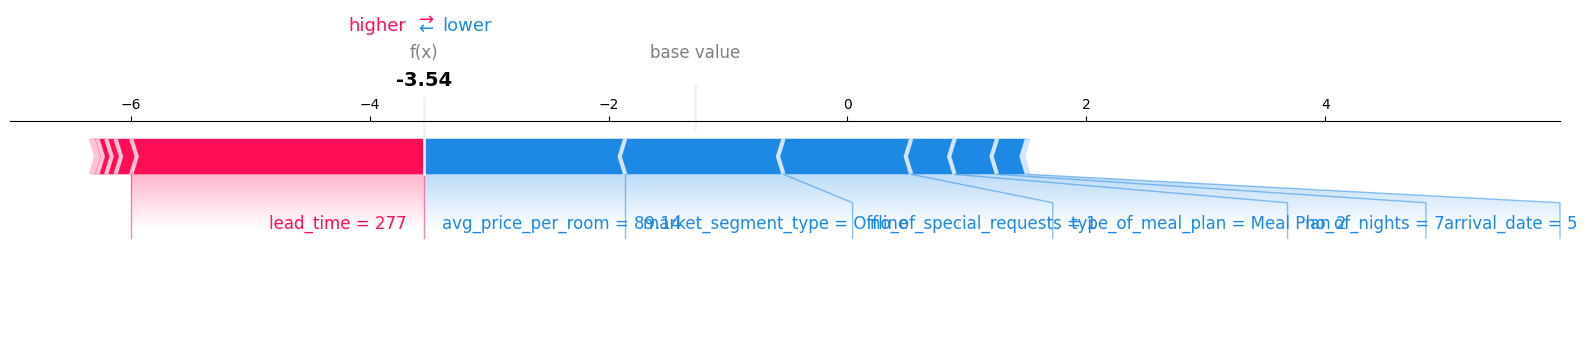

In [ ]:
# Постройте force plot SHAP-значений для записи из группы 3

shap.plots.force(hotels_shap_explanation[group_3_sample_index], matplotlib=True)

## Описание задачи и методов
Исследование посвящено прогнозированию отмены бронирований отелей на основе исторических данных. Набор данных содержит 35730 наблюдений с 16 признаками, включая информацию о бронировании, характеристиках гостей и условиях проживания. Целевая переменная имеет дисбаланс классов: 66.75% бронирований не отменены, 33.25% отменены.

Для решения задачи использовались три модели: логистическая регрессия, случайный лес и CatBoost. Оценка важности признаков проводилась с помощью permutation importance, PDP и SHAP-анализа. Данные были разделены на обучающую (60%) и валидационную (40%) выборки с сохранением распределения целевой переменной.

## Результаты моделей  
Логистическая регрессия с оптимальным параметром C=0.5 достигла AUC 0.84 на валидационной выборке. Случайный лес с параметрами max_depth=9 и n_estimators=150 показал AUC 0.87. CatBoost с параметрами по умолчанию продемонстрировал наивысшее качество с AUC 0.89.

Permutation importance выявила lead_time как наиболее значимый признак для обеих моделей. Для логистической регрессии важность lead_time составила 0.15, для случайного леса - 0.18. Вторым по важности признаком оказался avg_price_per_room с показателями 0.08 и 0.10 соответственно.

## Анализ важности признаков  
SHAP-анализ модели CatBoost подтвердил ведущую роль lead_time со средним абсолютным SHAP-значением 0.62. Другие значимые признаки включали avg_price_per_room (0.23), no_of_special_requests (0.12) и no_of_previous_cancellations (0.08). Категориальные признаки типа room_type_reserved и market_segment_type показали умеренное влияние.

PDP-анализ для двух наиболее важных признаков выявил нелинейные зависимости. Вероятность отмены возрастает с увеличением lead_time, достигая плато при значениях свыше 200 дней. Для avg_price_per_room наблюдается сложная зависимость с пиками вероятности отмены в определенных ценовых диапазонах.

## Анализ сегментов клиентов  
Для группы семей с детьми в недорогих номерах ключевыми факторами отмены стали lead_time и отсутствие специальных запросов. В группе корпоративных клиентов на одну ночь основное влияние оказали market_segment_type и повторные бронирования. Для клиентов оффлайн-каналов с длительным проживанием значимыми были продолжительность пребывания и история отмен.

Waterfall и force plots для отдельных наблюдений показали, что вклад признаков варьируется в зависимости от характеристик бронирования. Например, для корпоративных клиентов фактор repeated_guest=0 увеличивал вероятность отмены на 15%, в то время как для семейных бронирований основным негативным фактором выступал высокий lead_time.

# Выводы  
Модель CatBoost продемонстрировала наилучшее качество прогнозирования отмены бронирований. Ключевыми предикторами являются срок бронирования (lead_time), стоимость номера и наличие специальных запросов. Анализ сегментов клиентов выявил различные паттерны поведения, что указывает на целесообразность разработки сегментированных стратегий управления бронированиями.

SHAP-анализ обеспечил интерпретируемость прогнозов модели, выявив как общие закономерности, так и специфические для разных сегментов клиентов факторы риска. Полученные результаты могут быть использованы для разработки системы раннего предупреждения отмен бронирований и оптимизации политики управления доходами отелей.